## Capstone Project 1

This Jupyter Notebook documents the development of a Machine Learning project focused on predicting the price of Ford cars. The project aims to create a reliable and scalable solution for car price prediction using historical data, exploring patterns in features like mileage, year, and specifications.

### Project Overview

The objective is to predict the price of Ford cars based on their attributes. Accurate price predictions are crucial for car dealerships, online platforms, and individual sellers to make data-driven pricing decisions. This project provides a structured approach, from data exploration to model deployment, ensuring the solution is practical and usable.

### Data preparation

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1. Data Loading

In [36]:
data = pd.read_csv("ford_car_price_prediction.csv")
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Basic overview

In [37]:
df = pd.read_csv(data_path)
df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
5,Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
6,Puma,2019,22500,Manual,2029,Petrol,145,50.4,1.0
7,Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
8,Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2.0
9,Focus,2018,10000,Manual,48141,Petrol,145,61.4,1.0


In [38]:
data_path = "ford_car_price_prediction.csv"
print("First 10 lines of the dataset:")
!head $data_path

First 10 lines of the dataset:
model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
 Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1
 Focus,2018,14000,Manual,9083,Petrol,150,57.7,1
 Focus,2017,13000,Manual,12456,Petrol,150,57.7,1
 Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
 Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1
 Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
 Puma,2019,22500,Manual,2029,Petrol,145,50.4,1
 Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
 Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2


# 2. Exploratory Data Analysis (EDA)

In [39]:
print("\nColumns:", df.columns)
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())


Columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fuelType      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   float64
 8   engineSize    1460 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.8+ KB
None
              year         price       mileage          tax          mpg  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   2016.993836  12280.198630  21907.027397   108.205479 

In [40]:
target_label = "price"

In [41]:
# For demonstration, let's treat everything numeric (except the target) as features
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
if target_label in numeric_columns:
    numeric_columns.remove(target_label)

object_columns = df.select_dtypes(include=["object"]).columns.tolist()

X = df[numeric_columns]
y = df[target_label]
print("\nFeatures (X):", X.columns)
print("Target (y):", target_label)


Features (X): Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')
Target (y): price



Boxplot of numeric columns:


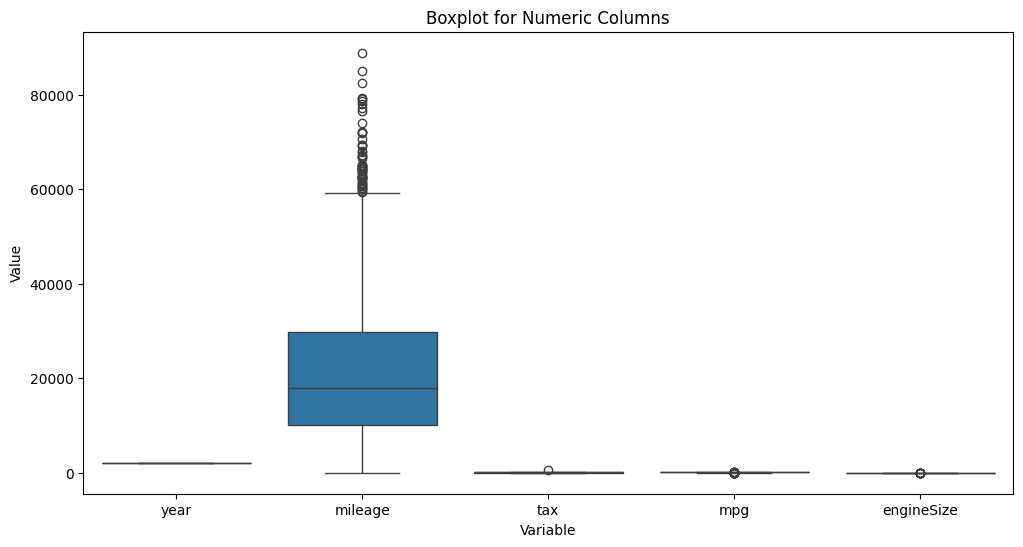

In [42]:
# Simple distribution plots for numeric columns
def showBoxplt(df_):
    df_melted = df_.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Variable", y="Value", data=df_melted)
    plt.title("Boxplot for Numeric Columns")
    plt.show()

print("\nBoxplot of numeric columns:")
showBoxplt(df[numeric_columns])

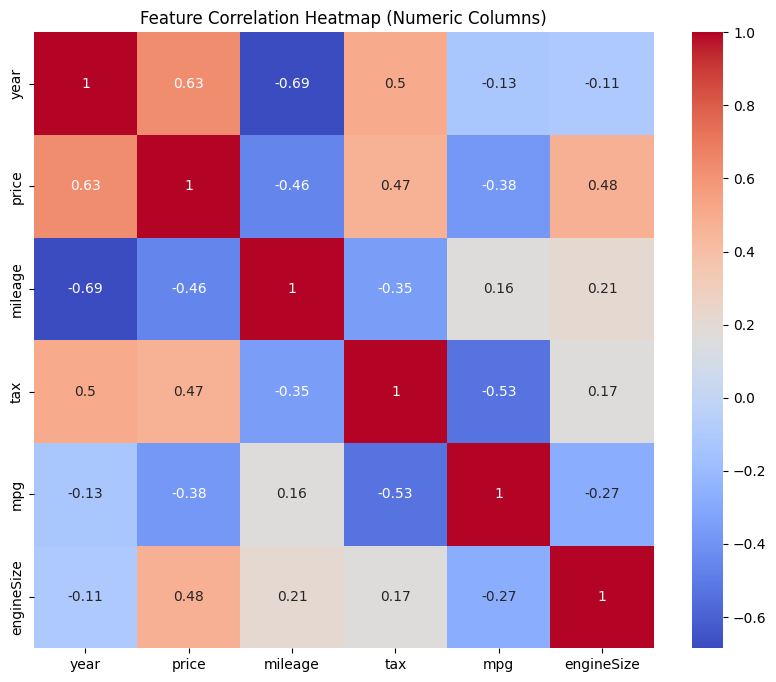

In [44]:
# Only compute correlation on numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Numeric Columns)")
plt.show()

In [47]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

if target_label in numeric_cols:
    correlation_target = df[numeric_cols].corr()[target_label].sort_values(ascending=False)
    print("\nCorrelation with target:", target_label)
    print(correlation_target)
else:
    print(f"'{target_label}' is not in numeric columns. Please ensure the target is numeric.")


Correlation with target: price
price         1.000000
year          0.628646
engineSize    0.478156
tax           0.470569
mpg          -0.378478
mileage      -0.456676
Name: price, dtype: float64


# (A) Histogram of Price

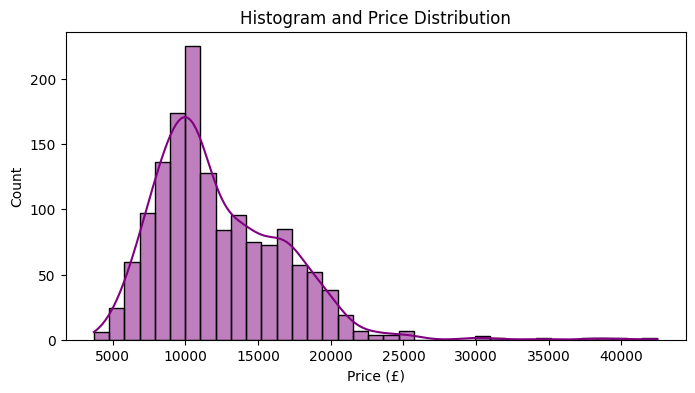

In [54]:
plt.figure(figsize=(8,4))
sns.histplot(data[target_label], kde=True, color='purple')
plt.title("Histogram and Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

# (B) Histograms/KDE of Numerical Columns

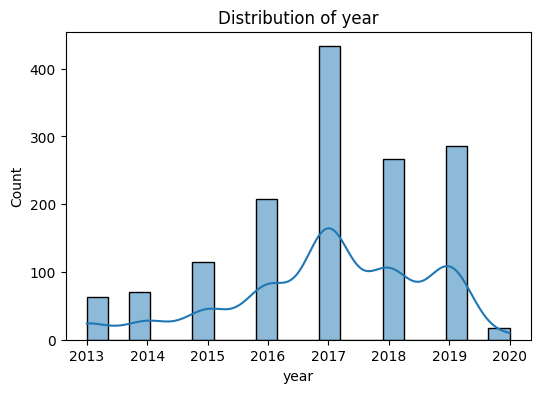

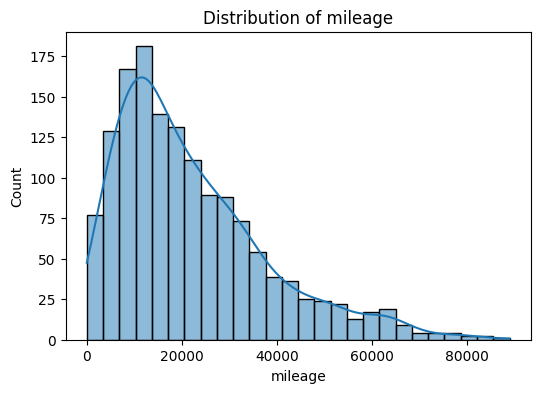

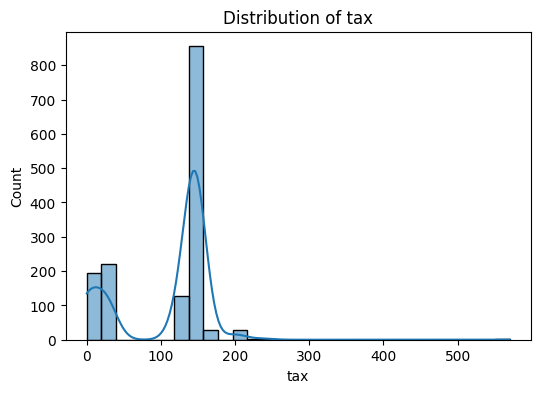

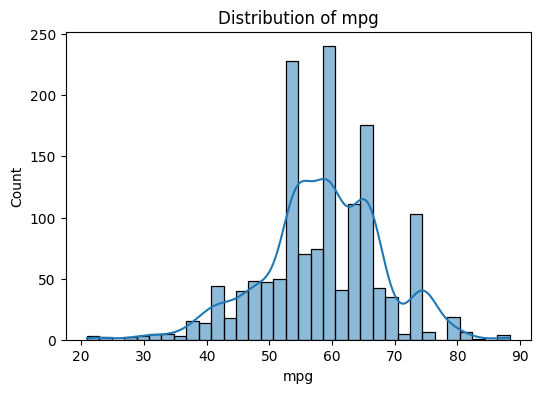

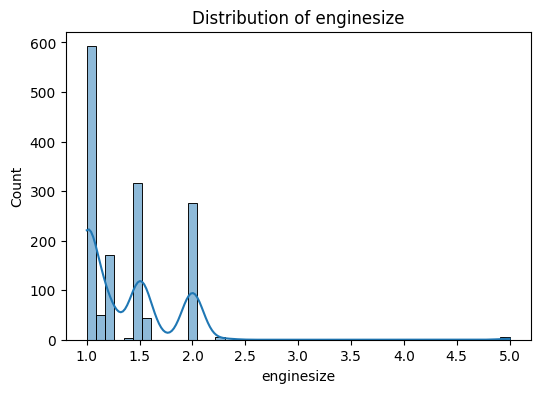

In [55]:
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# (C) Countplot of a Categorical Feature (Example: Brand)

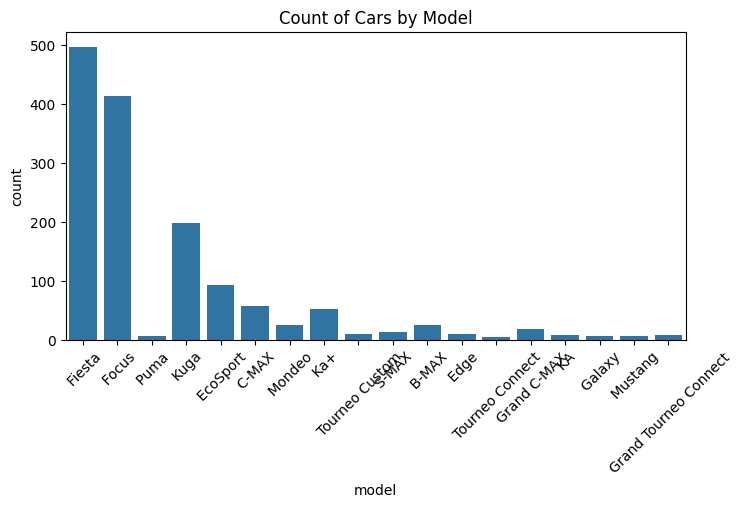

In [56]:
plt.figure(figsize=(8,4))
sns.countplot(x='model', data=data)
plt.title("Count of Cars by Model")
plt.xticks(rotation=45)
plt.show()

# (D) Violinplot: Brand vs. Price

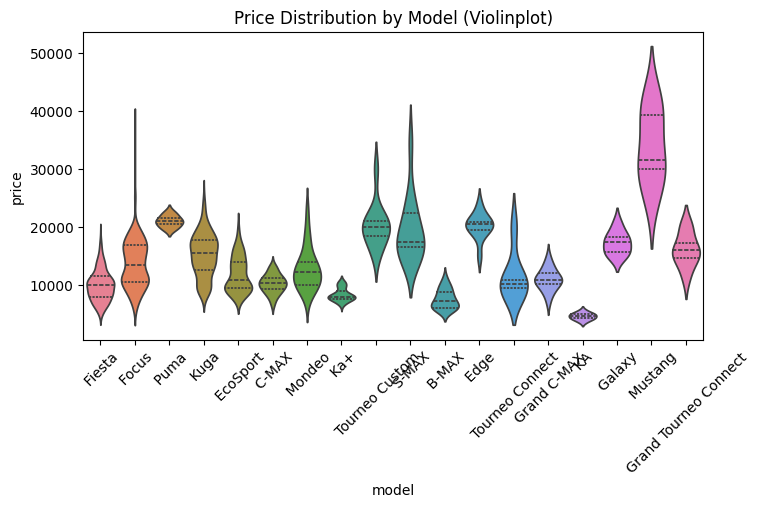

In [59]:
if 'model' in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.violinplot(
        x='model', 
        y=target_label, 
        data=data, 
        inner='quartile', 
        hue='model',
        legend=False
    )
    plt.title("Price Distribution by Model (Violinplot)")
    plt.xticks(rotation=45)
    plt.show()

# (E) Stripplot with Hue

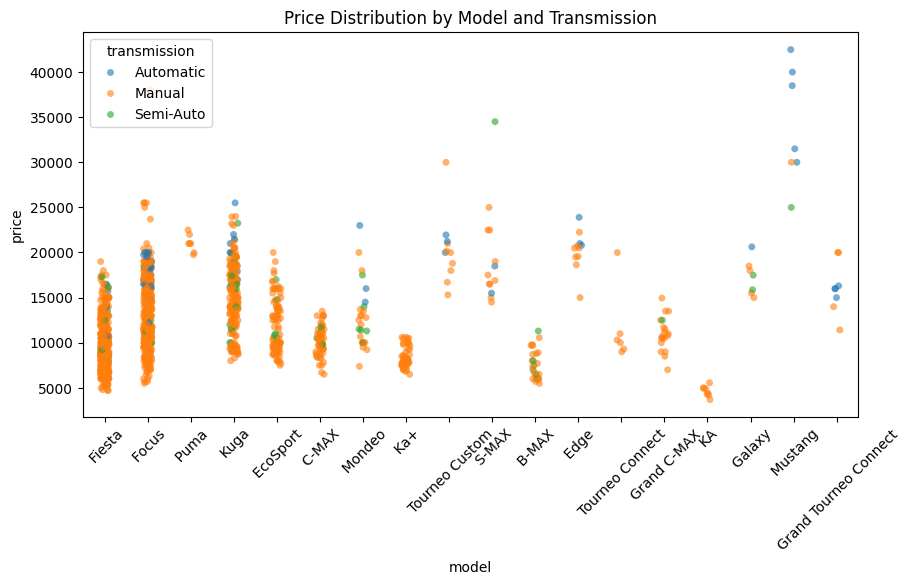

In [47]:
if 'model' in categorical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.stripplot(x='model', y='price', hue='transmission', data=data, jitter=True, alpha=0.6)
    plt.title("Price Distribution by Model and Transmission")
    plt.xticks(rotation=45)
    plt.show()

# (F) Boxplot of mpg vs Brand (if both exist)

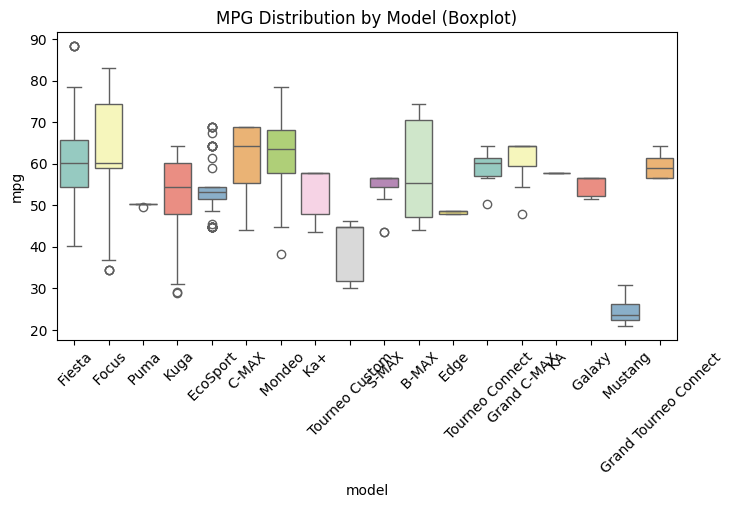

In [49]:
if 'model' in categorical_cols and 'mpg' in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='model', y='mpg', data=data, palette='Set3')
    plt.title("MPG Distribution by Model (Boxplot)")
    plt.xticks(rotation=45)
    plt.show()

# (G) Scatterplot mpg vs price, hue=transmission

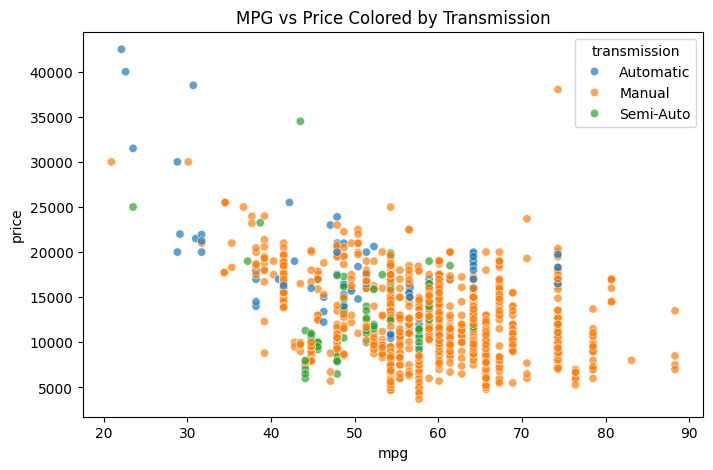

In [50]:
if 'mpg' in numerical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='mpg', y='price', hue='transmission', data=data, alpha=0.7)
    plt.title("MPG vs Price Colored by Transmission")
    plt.show()

# (H) Jointplot of Mileage vs. Price

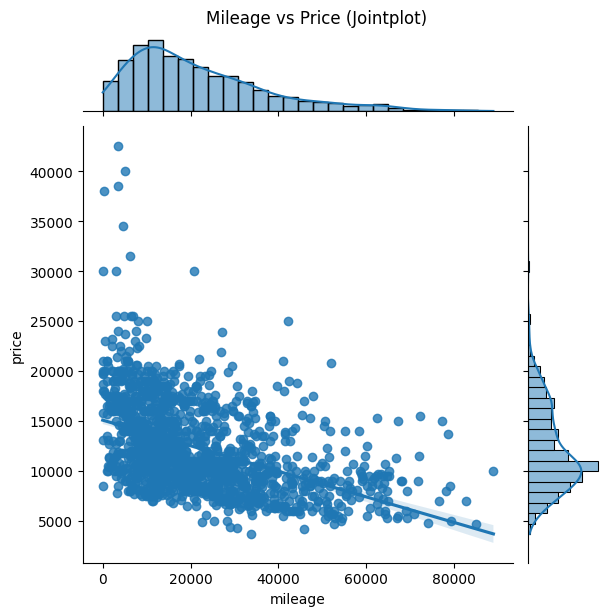

In [51]:
if 'mileage' in numerical_cols:
    sns.jointplot(x='mileage', y='price', data=data, kind='reg', height=6)
    plt.suptitle("Mileage vs Price (Jointplot)", y=1.02)
    plt.show()

# (I) Regplot of Engine Size vs Price

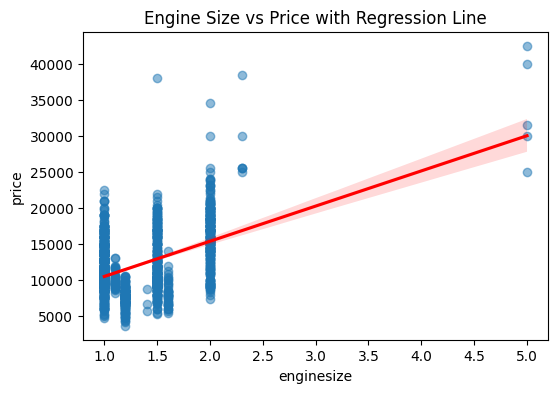

In [53]:
if 'enginesize' in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.regplot(x='enginesize', y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
    plt.title("Engine Size vs Price with Regression Line")
    plt.show()

# (J) Correlation Heatmap (Numerical + Price)

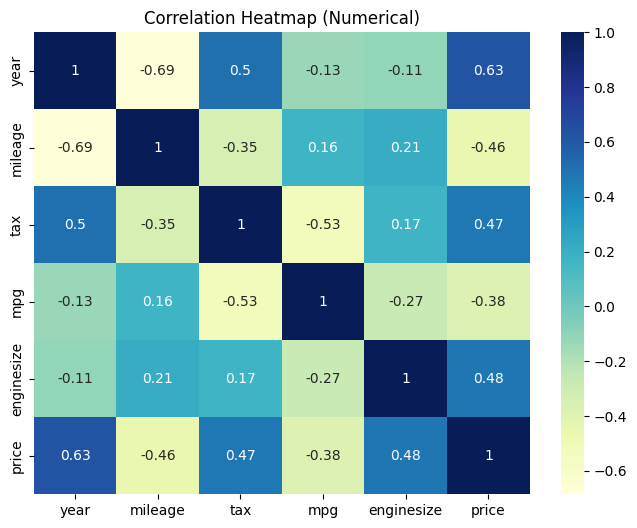

In [54]:
corr = data[numerical_cols + [target_label]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Numerical)")
plt.show()

# (K) Pairplot

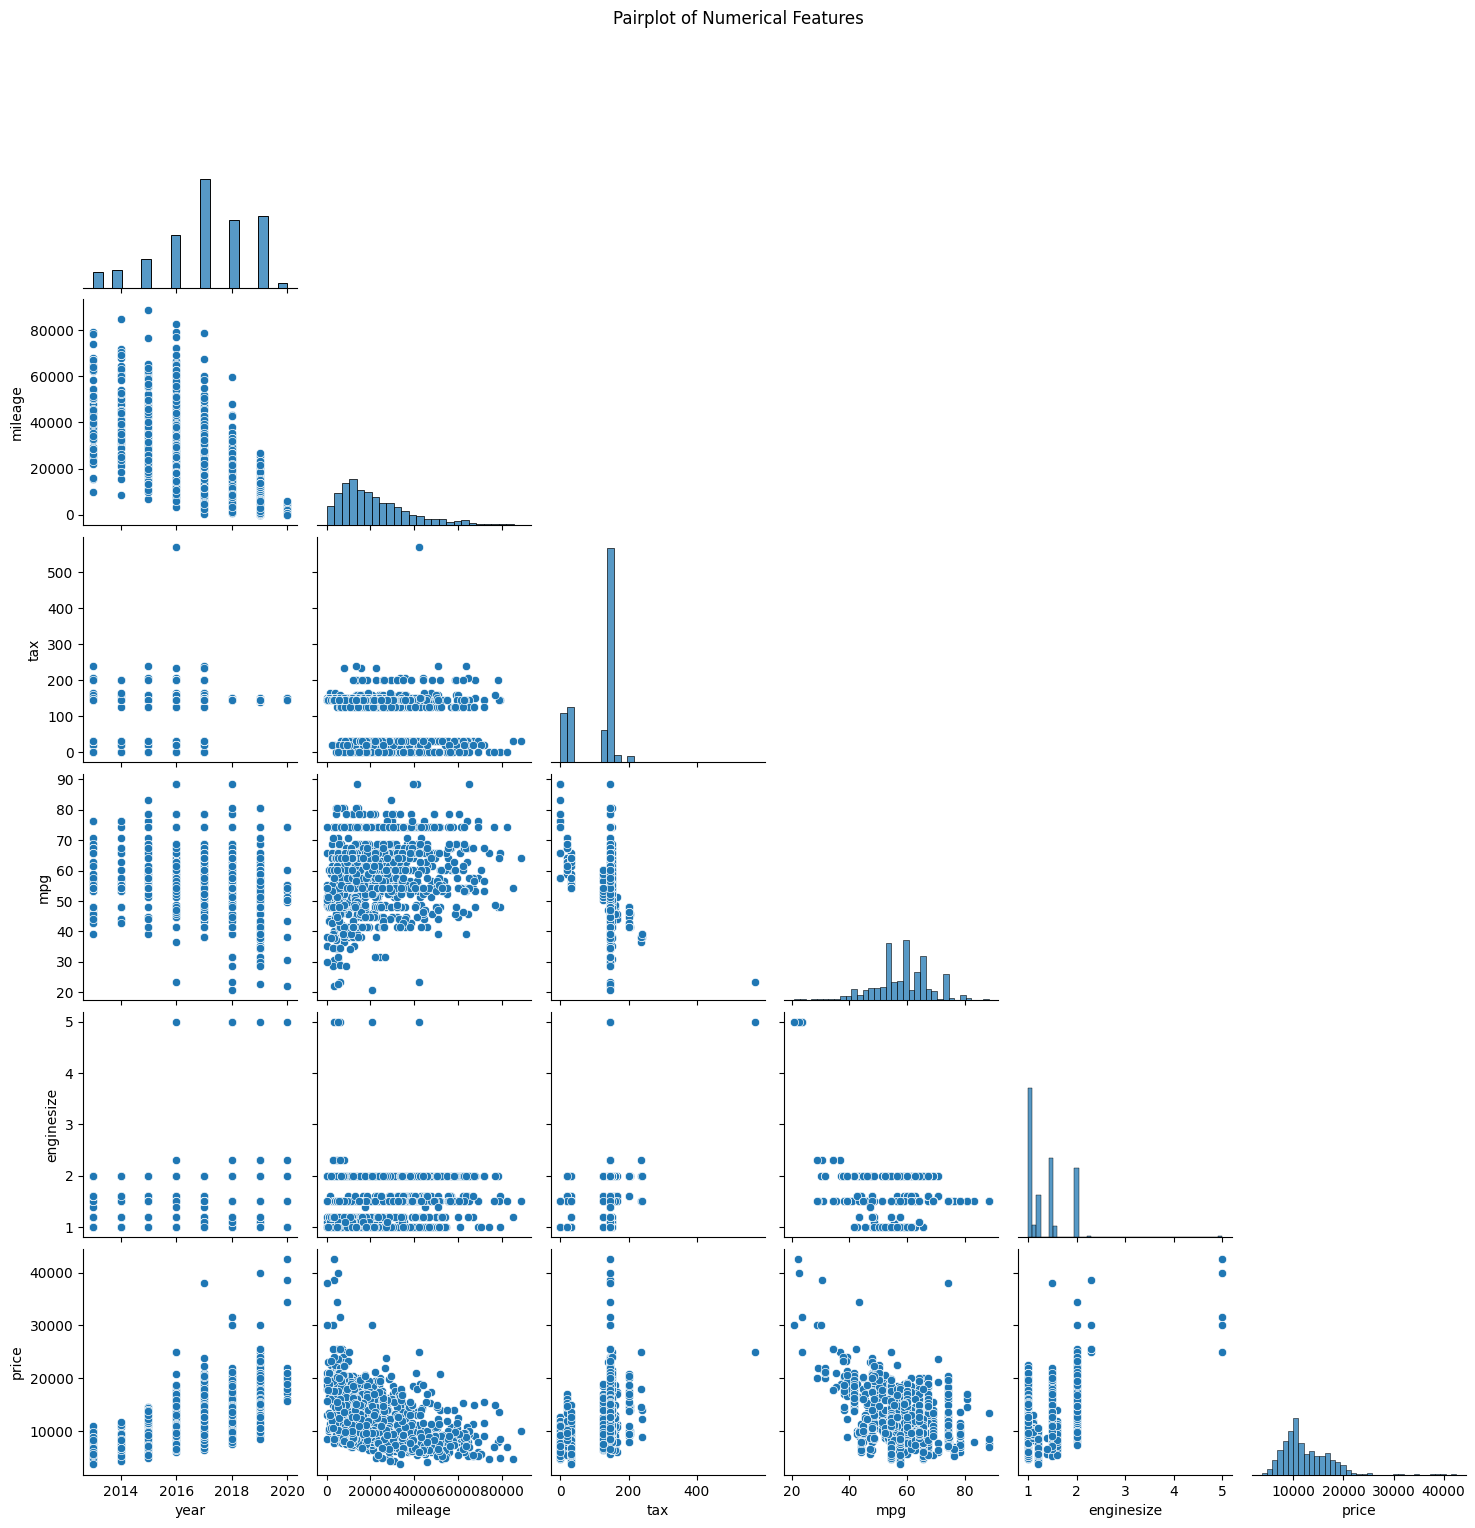

In [55]:
sns.pairplot(data, vars=numerical_cols + [target_label], corner=True)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

# 3. Data Preparation / Train-Test Split

In [56]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train[target_label].values
y_test_final = df_test[target_label].values

X_full_train = df_full_train.drop(columns=[target_label])
X_test_final = df_test.drop(columns=[target_label])

# 4. Preprocessing Pipeline

In [57]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# 5. Multiple Models

In [58]:
pipelines = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', LinearRegression())]),
    'Ridge': Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', Ridge())]),
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', Lasso())]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', XGBRegressor(objective='reg:squarederror',
                                                      random_state=42))])
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {
        'model__alpha': np.logspace(-4, 4, 10)
    },
    'Lasso': {
        'model__alpha': np.logspace(-4, 4, 10)
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

best_params = {}
results_list = []

for name, pipeline in pipelines.items():
    print(name)
    if param_grids[name]:
        grid = GridSearchCV(estimator=pipeline,
                            param_grid=param_grids[name],
                            scoring='neg_mean_squared_error',
                            cv=5)
        grid.fit(X_full_train, y_full_train)
        best_params[name] = grid.best_params_
        best_model = grid.best_estimator_
    else:
        pipeline.fit(X_full_train, y_full_train)
        best_model = pipeline
        best_params[name] = 'No parameter tuning'
    preds = best_model.predict(X_test_final)
    rmse = mean_squared_error(y_test_final, preds, squared=False)
    r2 = r2_score(y_test_final, preds)
    results_list.append((name, rmse, r2))

for item in results_list:
    print(item[0], "RMSE:", item[1], "R2:", item[2])

LinearRegression
Ridge


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Lasso


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBoost
LinearRegression RMSE: 1741.716522668865 R2: 0.8563362579484066
Ridge RMSE: 1744.5444613928855 R2: 0.855869359832495
Lasso RMSE: 1742.2732367850326 R2: 0.856244403258739
XGBoost RMSE: 1128.0238052347029 R2: 0.9397400617599487


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# 6. Final XGBoost Model with Chosen Hyperparams

In [59]:
params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50,
          "random_state": 42, "n_jobs": -1, "objective": "reg:squarederror"}
final_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('model', XGBRegressor(**params))]
)
final_pipeline.fit(X_full_train, y_full_train)
final_preds = final_pipeline.predict(X_test_final)
rmse_final = mean_squared_error(y_test_final, final_preds, squared=False)
r2_final = r2_score(y_test_final, final_preds)
print("Final XGBoost Model RMSE:", rmse_final, "R2:", r2_final)


Final XGBoost Model RMSE: 3480.897799894103 R2: 0.4261811375617981


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# 7. Save Pipeline

In [60]:
joblib.dump(final_pipeline, "pipeline.joblib")

['pipeline.joblib']